# Main questions

## Should the company sell its software for \$39 or \$59?
: this can be easily computed assuming we have enough sample representing the user behavior. 
We can compare the revenue rate, which is (price * converted / sample size) for test = 0,1 group and see if this test brought more revenue to the company. The assumptions are 

1. the test sample is randomly selected such that there is no meaningful trend, and that

2. if it were not for the test, the conversion rate for all the sample would have been identical to that of test=0 group.

1 can be tested by comparing the distribution of features in case of test=0 and 1. The result seems to indicate that there were more windows users who were in test=1 group than other OS. Also, we observed that more web users are tested with higher price than mobile users. Thus we would like the company to pay more attention in homogenizing the A/B testing groups.

Prior to this, we checked price is marked correctly based on test and how serious the contamination is. The conclusion is that the contamination is negligible, so we used test value to fill in the wrong price values.
<br>
Naive answer: <br>
revenue per visitor: 0.8269318181818182<br>
conversion rate for test=0: 0.019903614220108817<br>
conversion rate for test=1: 0.015542678810936857<br>
total revenue: 261972.0<br>
predicted revenue without price change: 245913.13441228846<br>
Thus moving to \$59 price will create more revenue! yay!

## The VP of Product is interested in having a holistic view into user behavior, especially focusing on actionable insights that might increase conversion rate. What are your main findings looking at the data?
: We do not know if the company has made software for each operating system, so we will take a look at them (assuming not many users have multiple operating system). If there is obvious visitor - buyer discrepancy in any of the categories, it will be the area to invest.
<br>
We also investigate if the source impacts the conversion behavior. It turns out that 

1. if a user is referred by a friend, they have the highest conversion rate by far, so it might be a good idea to start a promotion such that users referring the software to friends can get some benefit.

2. Google and Facebook ads are most efficient in converting people, so I hypothesize that checking the difference in how ads are done in those platforms will help designing / targeting future ads.

OS of the also exhibit distinct behavior:

1. "Apple" users (iOS, mac) seem to convert more than the rest (android, windows). This may be due to bias in user group itself (which is beyond the scope of the work here), or it can be due to the difference in design of the app in different platforms. The company can spend some time investigating how the software differs in apple-based and other platform. 

To further investigate on categories, I will encode all categorical variables and calculate the covariance matrix.

## The VP of Product feels that the test has been running for too long and she should have been able to get statistically significant results in a shorter time. Do you agree with her intuition? After how many days would you have stopped the test? Please, explain why.
: This is a power analysis. However, given that all the conclusions I listed above are REALLY significant, I agree that we have enough sample. However, for future test, we need to pay more attention to homogenizing the splits (e.g. device / OS), make sure to have the mentioned category (linux),  
<br>

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt

In [118]:
import numpy as np

In [93]:
df1 = pd.read_csv('test_results.csv', index_col=0)
df1.describe()
# there seems to be weird price values: 3074 price values are contaminated 
# (with meaningless 9-digit values)
# however, test is not contaminated, and it is "supposed to be" a direct measure of price: 
# test 0 == price 39, test 1 = price 59

,user_id,test,price,converted
count,316800.000000,316800.000000,3.168000e+05,316800.000000
mean,499281.341840,0.360079,6.457590e+06,0.018333
std,288591.154044,0.480024,6.797307e+07,0.134154
min,3.000000,0.000000,3.900000e+01,0.000000
25%,249525.750000,0.000000,3.900000e+01,0.000000
50%,499021.500000,0.000000,3.900000e+01,0.000000
75%,749025.500000,1.000000,5.900000e+01,0.000000
max,1000000.000000,1.000000,9.998843e+08,1.000000


In [ ]:
# test_result has 31800 users

/home/ijee/anaconda3/envs/insight/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


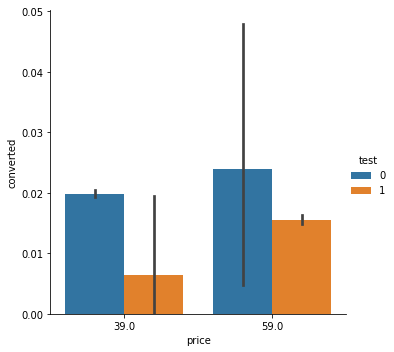

In [121]:
sns.catplot(x="price", y="converted", hue="test", kind="bar", data=df1.loc[df1['price']<60.0])

The above plot shows that there are small but incorrectly labeled data for both test 0 and 1. Let's find out how big they are, and fix them if necessary.

In [122]:
# 5808 users decided to purchase the software
# among them 1773 users were the test users
len(df1['test'].loc[(df1['test']==0) & (df1['price']==39)])
# there are 154 users where test = 1 and price = 39 (correctly 1 labeled, 200593)
# there are 209 users where test = 0 and price = 59 (correctly 0 labeled, 112770)
# since this is a very small fraction of contamination (~1%), let's proceed and correct the
# odd price values following their test label.

200593

In [123]:
df1['price'].loc[(df1['price']>60) & (df1['test']==0)] = 39.0
df1['price'].loc[(df1['price']>60) & (df1['test']==1)] = 59.0
df1['price'].unique()

/home/ijee/anaconda3/envs/insight/lib/python3.6/site-packages/pandas/core/indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


array([39., 59.])

/home/ijee/anaconda3/envs/insight/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


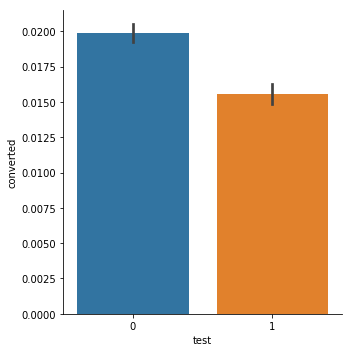

In [125]:
sns.catplot(x="test", y="converted", kind="bar", data=df1)

The above plot provides conversion rate for each group with 95% confidence interval: It does show that there is decrease in purchase as the price went up by \$20, as expected. This can be interpreted into net revenue based on the market size. 

In [139]:
vals=df1.groupby('test').sum().reset_index()
print('total revenue:', vals['converted'][0]*39.+vals['converted'][1]*59.)
print('revenue per visitor:', (vals['converted'][0]*39.+vals['converted'][1]*59.)/len(df1))
print('conversion rate for test=0:', vals['converted'][0]/len(df.loc[df['test']==0]))
print('conversion rate for test=1:', vals['converted'][1]/len(df.loc[df['test']==1]))
print('predicted revenue without price change:', len(df)*vals['converted'][0]/len(df.loc[df['test']==0])*39.0)

total revenue: 261972.0
revenue per visitor: 0.8269318181818182
conversion rate for test=0: 0.019903614220108817
conversion rate for test=1: 0.015542678810936857
predicted revenue without price change: 245913.13441228846


So it does seem like that using test group, the company achieved about 6.5% higher revenue. yay! <br>
Now let's test the distribution to make sure the A/B splitting is truely done random.

In [140]:
# They claimed they got linux, but they actually did not! instead they have nan... :<
df1['operative_system'].unique()

array(['iOS', 'android', 'mac', 'windows', nan, 'i0S', 'apple'],
      dtype=object)

In [99]:
# correcting typos
df1['operative_system'].loc[df1['operative_system']=='wnddows'] = df1['operative_system'].loc[df1['operative_system']=='wnddows'].map({'wnddows':'windows'})
df1['operative_system'].loc[df1['operative_system']=='anroid'] = df1['operative_system'].loc[df1['operative_system']=='anroid'].map({'anroid':'android'})

/home/ijee/anaconda3/envs/insight/lib/python3.6/site-packages/pandas/core/indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [142]:
df1['operative_system'].loc[df1['operative_system']=='i0S'] = df1['operative_system'].loc[df1['operative_system']=='i0S'].map({'i0S':'iOS'})

/home/ijee/anaconda3/envs/insight/lib/python3.6/site-packages/pandas/core/indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [143]:
df1['operative_system'].unique()

array(['iOS', 'android', 'mac', 'windows', nan, 'apple'], dtype=object)

In [152]:
len(df1['operative_system'].loc[df1['operative_system']=='apple'])
# there are 29 'apple' users... we can maybe use device info to put them into mac / iOS, 
# although it would not be statistically significant in any case.

29

In [163]:
len(df1['operative_system'].loc[df1['operative_system']=='windows'])
# there are 29 'apple' users... we can maybe use device info to put them into mac / iOS, 
# although it would not be statistically significant in any case.

100976

In [161]:
df1['operative_system'].isnull().sum()
# there are 20368 nan values!!!!! AND WHERE IS LINUX!!!!

20368

In [164]:
df1['operative_system'].loc[df1['device']=='mobile'].isnull().sum()
# most of the missing values are from mobile
# I was hoping that this will be all web and that it can be used as an arguement claiming that
# the missing values are for linux, but I guess I cannot........

16071

In [153]:
df1['operative_system'].loc[df1['operative_system']=='apple'] = df1['operative_system'].loc[(df1['operative_system']=='apple')&(df1['device']=='mobile')].map({'apple':'iOS'})
df1['operative_system'].loc[df1['operative_system']=='apple'] = df1['operative_system'].loc[(df1['operative_system']=='apple')&(df1['device']=='web')].map({'apple':'mac'})

/home/ijee/anaconda3/envs/insight/lib/python3.6/site-packages/pandas/core/indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


/home/ijee/anaconda3/envs/insight/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


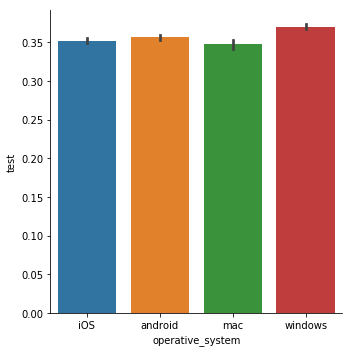

In [154]:
sns.catplot(x="operative_system", y="test", kind="bar", data=df1)
# There seems to be quite significantly more windows users sampled toward test=1

/home/ijee/anaconda3/envs/insight/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


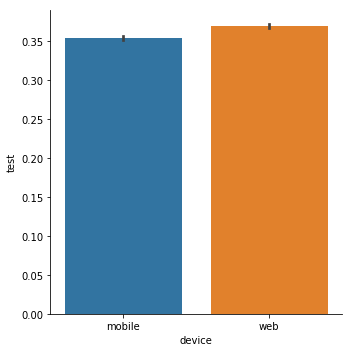

In [149]:
sns.catplot(x="device", y="test", kind="bar", data=df1)

/home/ijee/anaconda3/envs/insight/lib/python3.6/site-packages/seaborn/categorical.py:3692: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)
/home/ijee/anaconda3/envs/insight/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


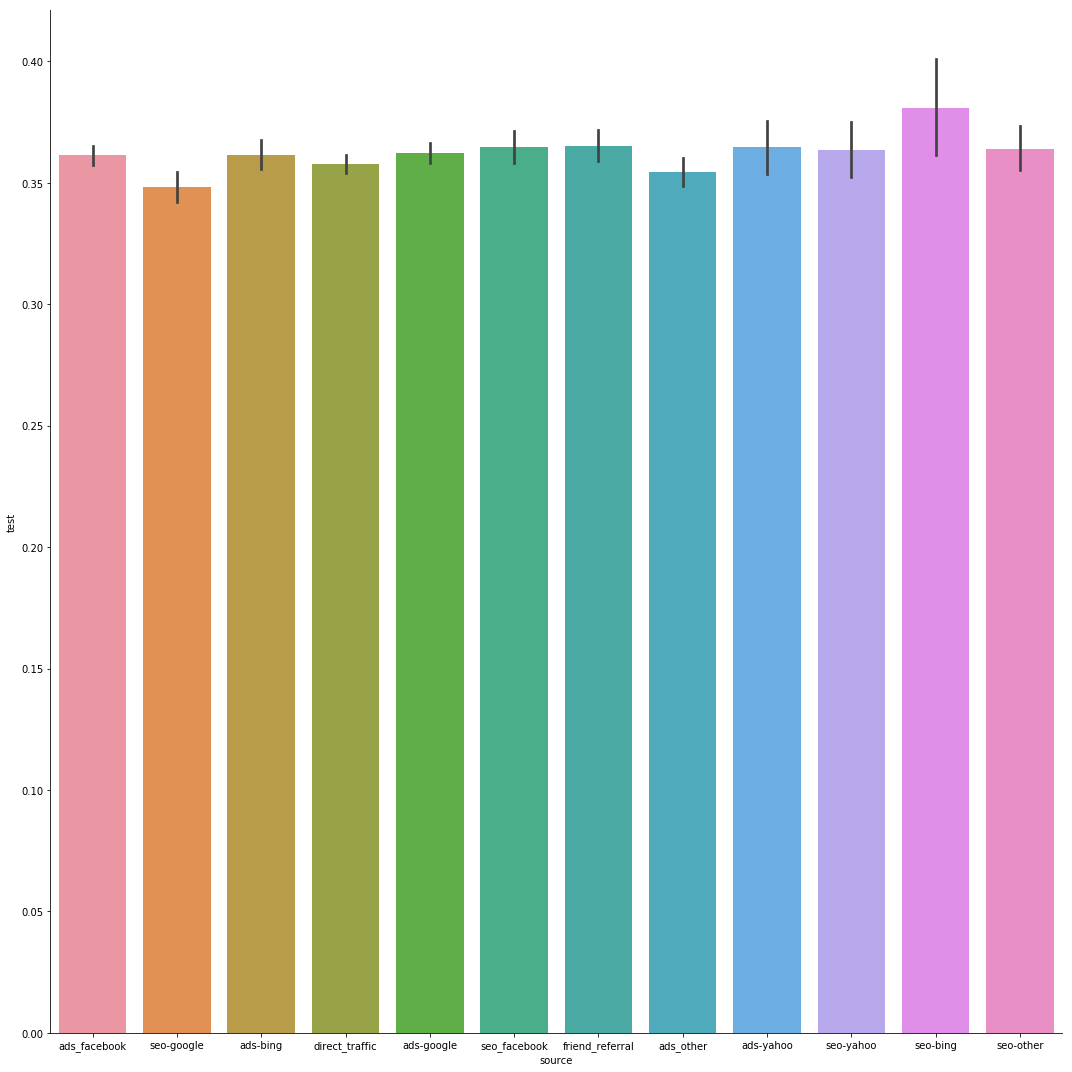

In [150]:
sns.catplot(x="source", y="test", kind="bar", data=df1, size = 15, aspect=1)
# there is slight undersampling in Seo-Google induced visitors in test=1 group, but the rest
# of the sources are fairly well distributed within 95% CI

In [102]:
# They claimed they got linux, but they actually did not! :<
df1['source'].unique()

array(['ads_facebook', 'seo-google', 'ads-bing', 'direct_traffic',
       'ads-google', 'seo_facebook', 'friend_referral', 'ads_other',
       'ads-yahoo', 'seo-yahoo', 'seo-bing', 'seo-other', nan],
      dtype=object)

/home/ijee/anaconda3/envs/insight/lib/python3.6/site-packages/seaborn/categorical.py:3692: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)
/home/ijee/anaconda3/envs/insight/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


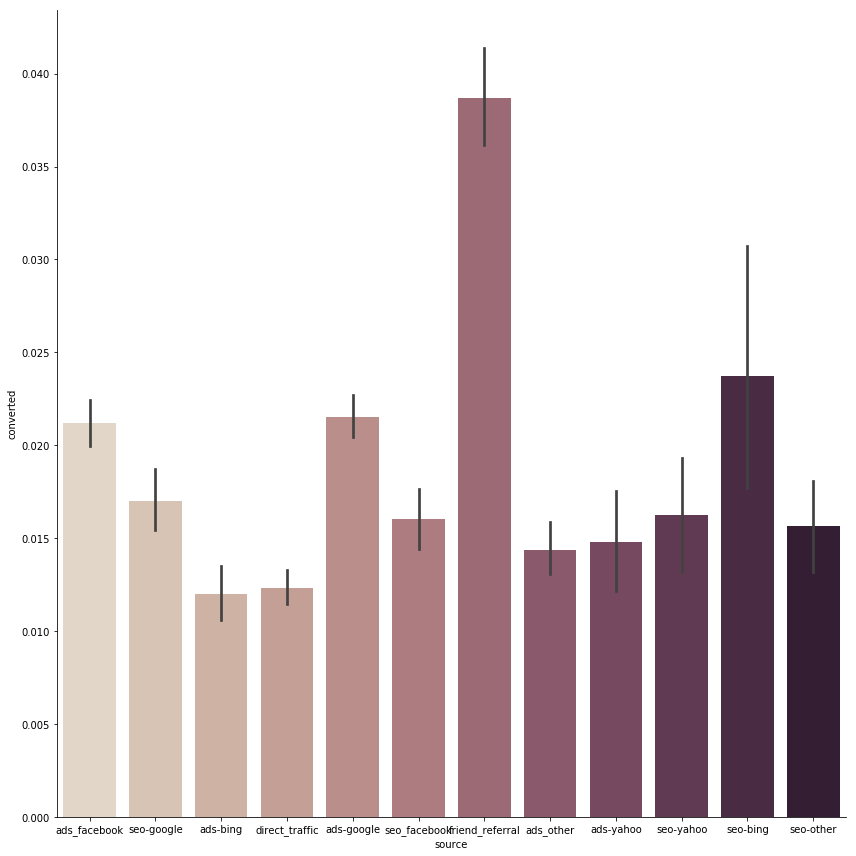

In [155]:
sns.catplot(x="source", kind="bar",y='converted', palette="ch:.25", data=df1,size=12, aspect=1);

This is GREAT! friend referral seems to show the highest conversion rate! Thus promoting users as they refer the software to friends might be a way to increase the conversion rate surely. While search engine results tend to be more-or-less the same given 95% interval, some ads turns out to be more effective than others in converting the users: e.g. Google and FB. It will be worth tracking what is different from Google / FB ads and the rest of the ads to see what is going on.

/home/ijee/anaconda3/envs/insight/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


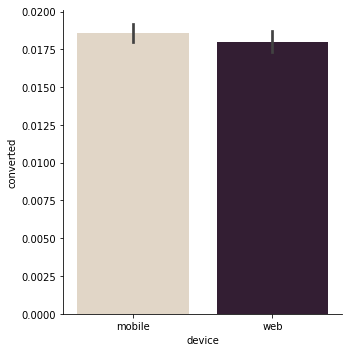

In [156]:
sns.catplot(x="device", kind="bar", y='converted', palette="ch:.25", data=df1);

/home/ijee/anaconda3/envs/insight/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


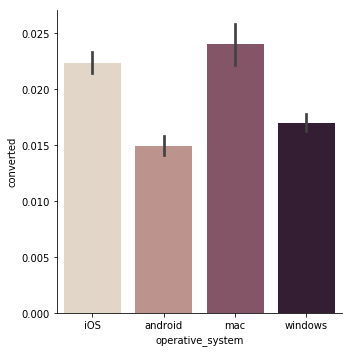

In [158]:
sns.catplot(x="operative_system", kind="bar",y='converted', palette="ch:.25", data=df1)

The software appears to be more appealing to 'apple' users (iOS for mobile, mac for web). This may be due to the difference in user (there must be market studies showing apple users tend to be... and windows/ android users tend to be... type of study, which is beyond the scope of 4 hr DC so we leave it for future work (which means it will never be touched)), or due to the design of the software in different OS, and thus it is worth investigating. 

Let's look at the correlation....

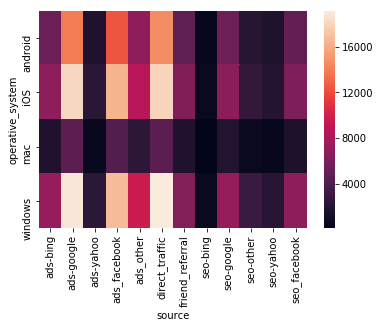

In [166]:
sns.heatmap(pd.crosstab(df1.operative_system, df.source))

In [35]:
df.loc[df['price']>60]

,user_id,timestamp,source,device,operative_system,test,price,converted,city,country,lat,long
94,713483,2015-05-01 22:14:32,direct_traffic,0,1.0,0,760350245.0,0,Cleveland,USA,41.48,-81.68
163,813855,2015-03-13 19:52:42,ads-bing,1,4.0,1,880279005.0,0,NaN,NaN,NaN,NaN
201,34593,2015-03-30 08:14:44,ads_other,0,2.0,0,630429505.0,0,Sacramento,USA,38.57,-121.47
271,878231,2015-03-20 01:08:07,ads-bing,1,3.0,0,991021920.0,0,Houston,USA,29.77,-95.39
289,951988,2015-05-02 13:20:25,ads_facebook,0,2.0,0,532089148.0,0,Jacksonville,USA,30.33,-81.66
403,839013,2015-03-06 10:52:08,ads_facebook,1,3.0,1,586982279.0,1,Eldersburg,USA,39.41,-76.94
425,589975,2015-04-26 08:54:42,ads_facebook,1,3.0,0,838114695.0,0,Rancho Cucamonga,USA,34.12,-117.57
517,298770,2015-05-18 12:54:04,ads-bing,1,4.0,0,991024673.0,0,Winston-Salem,USA,36.10,-80.26
548,165419,2015-04-10 04:29:28,friend_referral,0,2.0,0,731608106.0,0,Detroit,USA,42.38,-83.10
600,53480,2015-05-22 06:54:28,ads_facebook,0,2.0,0,582513317.0,0,Kennewick,USA,46.20,-119.17


In [17]:
df_user = pd.read_csv('user_table.csv')

,user_id,city,country,lat,long
0,510335,Peabody,USA,42.53,-70.97
1,89568,Reno,USA,39.54,-119.82
2,434134,Rialto,USA,34.11,-117.39
3,289769,Carson City,USA,39.15,-119.74
4,939586,Chicago,USA,41.84,-87.68


In [111]:
df_user['country'].unique()
# all users are in the US

array(['USA'], dtype=object)

In [19]:
df = pd.merge(df1, df_user, on='user_id', how='left')
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 316800 entries, 0 to 316799
Data columns (total 12 columns):
user_id             316800 non-null int64
timestamp           316466 non-null object
source              316488 non-null object
device              316800 non-null object
operative_system    296461 non-null object
test                316800 non-null int64
price               316800 non-null float64
converted           316800 non-null int64
city                275616 non-null object
country             275616 non-null object
lat                 275616 non-null float64
long                275616 non-null float64
dtypes: float64(3), int64(3), object(6)
memory usage: 31.4+ MB


In [71]:
df['timestamp']=pd.to_datetime(df['timestamp'],errors='coerce')
# The data is collected 2015 March - May

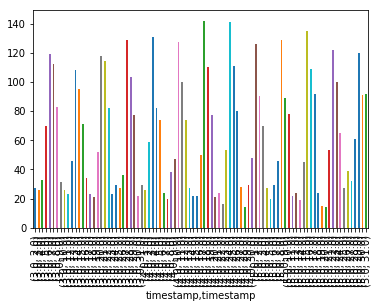

In [82]:
df['timestamp'].loc[df['converted']==1].groupby([df["timestamp"].dt.month, df["timestamp"].dt.day]).count().plot(kind="bar")
# seems to be a weekly variation in visitors
# converted seem to vary more every week compared to (more or less) stable visitor number

In [61]:
df['operative_system'].isnull().sum()
# about 6% of operating system info is missing (or does not make sense)

20658

In [62]:
df['timestamp'].isnull().sum()
# IS THIS EVEN NECESSARY? 

334

In [63]:
df['source'].isnull().sum()

312

In [64]:
df['city'].isnull().sum()

41184

In [65]:
df['country'].isnull().sum()

41184

In [66]:
df['lat'].isnull().sum()

41184

In [67]:
df['long'].isnull().sum()

41184

In [23]:
df['device'] = df['device'].map({'web':0, 'mobile':1})
# Do they have software developed for all the operating systems & mobile?
# Is there any trend in e.g. no mac users bought it because they have not implemented it in mac?
# will mobile purchase rate significantly lower / higher than web purchases?
df['operative_system'] = df['operative_system'].map({'linux':0, 'mac':1, 'windows':2,'iOS':3,'android':4,'Other':5})